<a href="https://colab.research.google.com/github/ameldocena/NetSci/blob/master/Retrieving_Sensitive_Samples_via_SMT_Solving_Proof_of_Concept_MLPs_ver_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieving Sensitive Samples via SMT Solving Proof of Concept - MLPs
We shall try experiments that will show the sensitivity of retrieved samples from different alternatives which we propose that an SMT solver can retrieve for us.  

Body:  
1. Simulate a DNN. Later on we can also take a real-world data set.
2. Build a DNN by hand.
3. Build a solver
4. Alternative methods
5. Graphs

Author: Amel Docena  
Date started: 30 Mar 2020  
Updates: Mar 31. Apr 1. Apr 2. Apr 3. 
Date ended: 


In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

In [0]:
#!pip install -U --pre tensorflow-gpu

In [0]:
!pip install z3-solver

     |████████████████████████████████| 19.3MB 1.3MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from z3 import *
import tensorflow as tf
import numpy as np
import time
import math as m
import random as rn
import pickle
import matplotlib.pyplot as plt

In [0]:
# import tensorflow as tf

feats = 5 #number of input features
# model = tf.keras.models.Sequential([tf.keras.layers.Dense(5, input_shape = (feats, ), activation = tf.nn.relu),
#                                     tf.keras.layers.Dense(5, activation = tf.nn.relu),
#                                     tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)])
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
              
# Generate dummy data
np.random.seed(1234)

#Here we simulate pixel inputs between [0, 255]
data = np.random.randint(0, 255, (10000, feats))/255 #we rescale the inputs between [0, 1]
labels = np.random.randint(2, size=(10000, 1))

# Train the model, iterating on the data in batches of 32 samples
# model.fit(data, labels, epochs=10, batch_size=1000)
# model.save("/content/gdrive/My Drive/simulated_mlp.h5")              

In [0]:
#Load the trained model
model = tf.keras.models.load_model("/content/gdrive/My Drive/simulated_mlp.h5")
params = model.get_weights()
print("Trained model weights:", params)

Trained model weights: [array([[ 0.37967074,  0.5596039 , -0.7366209 , -0.28183615, -0.38251448],
       [ 0.4717966 ,  0.4437042 , -0.5648101 , -0.5899938 ,  0.5305186 ],
       [ 0.43645683,  0.41250747, -0.4090513 ,  0.39053267, -0.12813646],
       [ 0.3251615 ,  0.6047335 , -0.49429867, -0.05936195,  0.67315966],
       [-0.26735654, -0.27181953,  0.3767387 , -0.37615106,  0.6860024 ]],
      dtype=float32), array([-0.05240263,  0.05733198,  0.01772672, -0.01130863, -0.05929317],
      dtype=float32), array([[ 0.24453026, -0.2242428 ,  0.5843106 ,  0.317849  ,  0.38699338],
       [-0.06821752, -0.60588133, -0.4516444 ,  0.789883  , -0.69673383],
       [-0.43143904,  0.16242248, -0.0687018 ,  0.55008376,  0.7060163 ],
       [ 0.7079289 , -0.3274759 ,  0.7401523 ,  0.33462423,  0.49848706],
       [ 0.49951464, -0.09326637, -0.403249  , -0.58855516,  0.03080926]],
      dtype=float32), array([-0.05477079,  0.        , -0.00274935,  0.05645065,  0.02942853],
      dtype=float32), 

## Forward propagation
We shall hand code fordward propagation of an MLP. This will come in handy for Alternative 1 where we approximate the optimal sensitivity.


In [0]:
def StoreParams(params):
    """
    This function shall take in the parameters of Keras output and segregate the weights and biases, 
    storing them into separate containers.
    
    Inputs:
    params - parameters output by Keras
    
    Return:
    A dictionary which contains W, a container for the weights, and B, a container for the biases
    """
    
    #Store the weights and biases
    W = dict()
    B = dict()
    params_dummy = params
    for layer in range(int(len(params)/2)):
        W['W'+str(layer+1)] = params_dummy[0]
        B['B'+str(layer+1)] = params_dummy[1]
        params_dummy = params_dummy[2:]

    #print("Weights:", W)
    #print("Biases:", B)
    
    #Output
    output = dict()
    output['W'] = W
    output['B'] = B
    
    return output

In [0]:
def ReLU(x):
  #Returns a ReLU activated
  return x*(x>0)

In [0]:
def Sigmoid(x):
  #Returns sigmoid of x
  return 1/(1+np.exp(-x))

In [0]:
def ForwardProp(data, W, B):
    """
    This function shall forward propagate the data/inputs through the DNN and compute output.
    
    Inputs:
    data - input data
    W - weights matrix
    B - biases
    
    Return: A dictionary containing linear forward layers and activated layers, which include predictions
    """
    
    #Instantiate
    Z = dict() #container for linear layers
    A = dict() #container for activated layers
    A['A0'] = data.T #training data
    
    #Do forward propagation
    for layer in range(len(W)):
        weight = np.vstack((W['W'+str(layer+1)], B['B'+str(layer+1)]))
        variable = np.vstack((A['A'+str(layer)], np.ones(A['A'+str(layer)].shape[1])))
        Z['Z'+str(layer+1)] = np.dot(weight.T, variable)
        A['A'+str(layer+1)] = ReLU(Z['Z'+str(layer+1)])
    A.pop('A'+str(len(W)))
    #print("Linear layers:", Z)
    #print("Activated layers:", A)
    
    yhat = Sigmoid(Z['Z'+str(len(W))])
    
    #Output
    output = dict()
    output['Z'] = Z
    output['A'] = A
    output['yhat'] = yhat
    
    return output

In [0]:
#Compute the percentage change: Given a vector of percentage change in weight for each of the neurons of the last layer, we shall compute for the
#unit change in the weights.

def Delta(change, weight):
    """
    Computes the corresponding unit change in weight for each of the neurons of the last layer given a vector
    of percentage change.
    
    Inputs:
    change - a vector of percentage change (+/-) for each of the neuron weights of the output layer
    weights - weights of the output layer
    
    Return: a vector of corresponding unit weight change for the neurons of the output layer
    """
    return np.multiply(weight, np.array([change]).T)

In [0]:
#Approximate mhat

def Mhat(delta, weight, layer):
    """
    Approximates the mhat that corresponds to the max sensitivity after a weight change in the output layer.
    
    Inputs:
    #change - a vector of percent changes in the weights of the output layer
    delta - unit weight change for the neurons in the output layer
    weight - weight matrix of the output layer
    layer - A[L-1] layer, i.e., the activated layer prior to the output layer
    
    Return: max sensitivity for a given weight change, delta
    """
    m = np.dot(delta.T, layer) #sensitivity of all samples after a weight change, delta
    mhat_index = np.argmax(np.abs(m)) #index that corresponds to the max sensitivity in absolute terms
    mhat = m[0, mhat_index]
    print("mhat:", mhat)
    return mhat

In [0]:
def simulateWeightChange(perc_change, target_shape):
  """
  This function simulates a weight change by repeating perc_change by the length
  of the target weight. Equivalently, this applies a uniform perc_change to each
  of the neurons in the target layer.
  Inputs:
    perc_change - percent change applied to a neuron weight
    target_shape - the number of neurons in target layer whose weight will be 
      applied with perc_change
  Returns: the change vector
  """
  change = np.repeat(perc_change, target_shape)
  return change

### Step 3. Develop a Tool that spells out the formulas to a Solver
Given weights and bias matrices, can we spell out the formulas to a solver? Here we shall use the Z3 Python API.

In [0]:
#Activation fcn: ReLU in Z3
def ReLU_z3(x):
    """
    This function defines ReLU in Z3.
    """
    return If(x<=0, 0, x)

In [0]:
def SensitiveSample(S, inputs):
    """
    This shall compile the sensitive sample, if any, into an array/list.
    
    Inputs:
    S - solver
    inputs - input variables
    
    Return: Sensitive sample, if any, stored in a list
    """
    
    if str(S.check())=='sat':
        sensitive_sample = list()
        for var in inputs:
            sensitive_sample.append(S.model()[var])
        return sensitive_sample
    
    else:
        print("Model unsatisfiable")
        return None

In [0]:
def CheckModel(s, check = False):
    """
    Checks whether model is satisifiable. If yes, prints the model.
    Otherwise, prints unsatisfiable.
    """
    tic = time.process_time()
    if str(s.check())=='sat':
        print(s.check())
        if check is True:
          print(s.model())
        toc = time.process_time()
        runtime = str(1000*(toc - tic))
        print ("\nComputation time = " + runtime + "ms")

    else:
        print(s.check())
        toc = time.process_time()
        runtime = str(1000*(toc - tic))
        print ("\nComputation time = " + runtime + "ms")
    return runtime

In [0]:
#We have to enforce a range for possible values of our inputs
def MLPSolverBuilder1(W, B, change, input_range = None, check = False):
  """
  This function builds a solver for an MLP type of DNN. The variables are declared as double-precision floating point numbers.
  And the activation function in the hidden layers is ReLU. The final neuron that is computed is the linear forward in the output layer.
  Inputs: 
    W, B - trained weight matrix and bias matrix,
    input_range - a tuple of range of possible values of our sensitive sample
    #mhat - approximated sensitivity
    change - vector containing percent weight change applied in the output layer
  Return: Solver for an MLP
  """

  #Step 1: Instantiate Z3 variables as double-precision floating pt numbers
  variables = dict()

  #Linear forward variables
  for layer in range(len(W)):
      variables['z' + str(layer+1)] = list()
      for neuron in range(W['W'+str(layer+1)].shape[0]):
          variables['z' + str(layer+1)].append(Real('z' + str(layer+1) + "_" + str(neuron+1)))

  #Activation variables
  for layer in range(len(W)):
      variables['a' + str(layer)] = list()
      for neuron in range(W['W'+str(layer+1)].shape[0]):
          variables['a' + str(layer)].append(Real('a' + str(layer) + "_" + str(neuron+1)))

  #Dot product between the paramters and the z3 variables to spell out the formulas
  formulas = dict()
  for layer in range(len(W)):
      weights = np.vstack((W['W'+str(layer+1)], B['B'+str(layer+1)]))
      var = variables['a'+str(layer)].copy()
      var.append(1)
      formulas['z'+str(layer+1)] = np.dot(weights.T, var)

  #Step 2. Set up the solver
  S = Solver()

  #Linear formulas
  for layer in range(len(W)):
      for neuron in range(len(formulas['z'+str(layer+1)])):
          S.add(variables['z' + str(layer+1)][neuron] == formulas['z'+str(layer+1)][neuron])
          
  #Activation formulas
  if len(W)>1:
      for layer in range(1, len(W)):
          for neuron in range(len(variables['a'+str(layer)])):
              S.add(variables['a'+str(layer)][neuron] == ReLU_z3(variables['z'+str(layer)][neuron]))

  #Range of each sensitive input
  if input_range!=None:
    xmin = input_range[0] #min delta
    xmax = input_range[1] #max delta
    for input in variables['a0']:
        S.add(And(input>=xmin, input<=xmax))
  else: print("No input range given.")

  #Optimal condition formula(s)
  delta = Delta(change, W['W'+str(len(W))])
  mhat = Mhat(delta, W['W'+str(len(W))], A['A'+str(len(W)-1)])
  print("z-star:", -mhat/2)
  S.add(variables['z'+str(len(W))][0] == -mhat/2) #optimal condition for the output layer
  S.add(np.dot(variables['a'+str(len(W)-1)], delta)[0] == mhat) #maximum sensitivity

  #Check model
  runtime = CheckModel(S, check)
  if check is True:
    S
  #Store the samples if satisfiable
  sens_sample = SensitiveSample(S, variables['a0'])
  print("Solved sample:", sens_sample)
  
  output = dict()
  output['model'] = S
  output['sens_sample'] = sens_sample
  output['runtime'] = runtime
  return output                   

In [0]:
check = False
if check==True:
  print(True)
if check is True:
  print(True)

### Step 4. Solve for Sensitive Sample
Here our conditions for the sensitive sample is that it should be around the decision boundary, such that after the tweaking the label will be misclassified than what it should have been.

In [0]:
#Stored variables and parameters
W = StoreParams(params)['W']
B = StoreParams(params)['B']

manual = ForwardProp(data, W, B)
Z = manual['Z']
A = manual['A']

In [0]:
#Sanity Check
#We ensure that our forward propagation is correct. We can compare our predictions to the predictions made by Tensorflow
manual = ForwardProp(data, W, B) #manual predictions
predict = model.predict(data) #predictions made by Tensorflow
print("Sanity check, (pred, manual): Should be the same\n", np.concatenate((predict, manual['yhat'].T), axis = 1)[0:5, :])

Sanity check, (pred, manual): Should be the same
 [[0.53862649 0.53862649]
 [0.50971961 0.5097196 ]
 [0.5269596  0.5269596 ]
 [0.49266088 0.49266089]
 [0.48871589 0.48871589]]


In [0]:
#Solve for sensitive sample
change = [0, 0, 0, 0, -0.5]
S1 = MLPSolverBuilder1(W, B, change, input_range=(0, 1), check = True)

mhat: 0.03335245107937848
z-star: -0.01667622553968924
sat
[a1_3 = 5759759532785879594704626184001356703770749532419932507545881429/27924874399451924053323962618454808963101169572600678744440856773,
 z3_1 = -416905638492231/25000000000000000,
 z1_3 = 5759759532785879594704626184001356703770749532419932507545881429/27924874399451924053323962618454808963101169572600678744440856773,
 a2_4 = 0,
 a0_2 = 5728228255396425370021240824467576469060508657909797203509080737862966752159649246059254467230319/20202395816022861727515286640721496321637181447639041445790599859858737600319587931521630216849905,
 a2_5 = 555874184656308/2797232319911321,
 z2_1 = 29306497660467424237818534162359/122090032659723699478975862924320,
 a0_4 = 0,
 a0_1 = 0,
 z2_3 = -364982196787168897240308026150875525775477606834074533643698441959052564047859929/1116994975978076962132958504738192358524046782904027149777634270920000000000000000,
 z2_5 = 555874184656308/2797232319911321,
 a2_2 = 0,
 z1_4 = -10666038626557934056919

In [0]:
#Sensitive sample
sensitive_sample1 = np.array([[0, 5728228255396425370021240824467576469060508657909797203509080737862966752159649246059254467230319/20202395816022861727515286640721496321637181447639041445790599859858737600319587931521630216849905, 1385785159127762058534562586262514768984239800013790816995899362646960481082930502145087042528769/20202395816022861727515286640721496321637181447639041445790599859858737600319587931521630216849905, 0, 1]])
print("Sensitive sample 1:", sensitive_sample1.shape, sensitive_sample1)

Sensitive sample 1: (1, 5) [[0.         0.28354203 0.06859509 0.         1.        ]]


### Graph 1. Show the sensitivity of the sample is equal to or greater than other training samples

In [0]:
def TweakOutputWeights(W, change):
    """
    This function shall tweak the output weights given a weight matrix and a change-vector, 
    which contains percentage change (could be 0) to each of the neurons in the output layer. 
    Note that the dimensions of the change-vector must be congruent to the output layer.
    
    Inputs:
    W - a dictionary containing the weights of each layer
    change - a vector/list containing percentage change to each of the neurons in the output layer
    """
    
    tweaked_W = W.copy()
    tweaked_W['W'+str(len(W))] = tweaked_W['W'+str(len(W))] + np.multiply(W['W'+str(len(W))], np.array([change]).T)
    
    #print("Tweaked Weights:", tweaked_W)
    return tweaked_W

In [0]:
def TweakInnerWeights(W, layer, change):
  """
  This function tweaks the weight in layer by the percentage change
  Inputs:
    W - weight matrix
    layer - inner weight layer
    change - percentage change, has the same dimension as W[layer]
  Returns:
    tweaked_W - tweaked weights
  """
  tweaked_W = W.copy()
  tweaked_W['W'+str(layer)] = tweaked_W['W'+str(layer)] + np.multiply(W['W'+str(layer)], change)

  return tweaked_W

In [0]:
W['W2'].shape

(5, 5)

In [0]:
#First-cut
zeros = np.repeat(0, W['W2'].shape[0])
ones = np.repeat(1, W['W2'].shape[0])
c = np.repeat(-0.5, W['W2'].shape[0])
print(zeros.shape, zeros)
print(c.shape, c)
cmat = np.array([zeros, zeros, zeros, zeros, c]).T
print(cmat.shape, cmat)

(5,) [0 0 0 0 0]
(5,) [-0.5 -0.5 -0.5 -0.5 -0.5]
(5, 5) [[ 0.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   0.  -0.5]]


In [0]:
#verification
d = np.array([ones, ones, ones, ones, ones])
print(d)
d + np.multiply(d, cmat)

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


array([[1. , 1. , 1. , 1. , 0.5],
       [1. , 1. , 1. , 1. , 0.5],
       [1. , 1. , 1. , 1. , 0.5],
       [1. , 1. , 1. , 1. , 0.5],
       [1. , 1. , 1. , 1. , 0.5]])

In [0]:
tweaked_inner = W.copy()
tweaked_inner['W2'] = tweaked_inner['W2'] + np.multiply(tweaked_inner['W2'], cmat)
print("orig:\n", W['W2'])
print("tweaked:\n", tweaked_inner['W2'])
sens_inner = np.abs(ForwardProp(sensitive_sample1, W, B)['yhat'] - ForwardProp(sensitive_sample1, tweaked_inner, B)['yhat'])
sens_inner

orig:
 [[ 0.24453026 -0.2242428   0.5843106   0.317849    0.38699338]
 [-0.06821752 -0.60588133 -0.4516444   0.789883   -0.69673383]
 [-0.43143904  0.16242248 -0.0687018   0.55008376  0.7060163 ]
 [ 0.7079289  -0.3274759   0.7401523   0.33462423  0.49848706]
 [ 0.49951464 -0.09326637 -0.403249   -0.58855516  0.03080926]]
tweaked:
 [[ 0.24453026 -0.22424281  0.58431059  0.31784901  0.19349669]
 [-0.06821752 -0.60588133 -0.45164439  0.78988302 -0.34836692]
 [-0.43143904  0.16242248 -0.0687018   0.55008376  0.35300815]
 [ 0.7079289  -0.32747591  0.7401523   0.33462423  0.24924353]
 [ 0.49951464 -0.09326637 -0.403249   -0.58855516  0.01540463]]


array([[0.00710321]])

In [0]:
def Sensitivity(data, W, B, change):
  """
  This function computes the sensitivty of the data to a given percent weight change
  Inputs: 
    data - input samples
    W, B - trained parameters
    change - vector of percentage change
  """
  tweaked_W = TweakOutputWeights(W, change)
  sensitivity = np.abs(ForwardProp(data, W, B)['yhat'] - ForwardProp(data, tweaked_W, B)['yhat'])
  
  return sensitivity

In [0]:
#Check for the sensitivity of the data
print("change:", change)
opt_sens = Sensitivity(sensitive_sample1, W, B, change) #optimal sensitivity
train_sens = Sensitivity(data, W, B, change) #sensitivity of our training samples

print("Sensitivity of sensitive sample >= among training samples:", opt_sens >= np.max(train_sens))
print("Optimal sensitivity:", opt_sens, "Max sensitivity among training samples:", np.max(train_sens))
print("Count sensitive training samples:", np.count_nonzero(train_sens), ". Ratio:", np.count_nonzero(train_sens)/train_sens.shape[1])

change: [0, 0, 0, 0, -0.5]
Sensitivity of sensitive sample >= among training samples: [[ True]]
Optimal sensitivity: [[0.00833792]] Max sensitivity among training samples: 0.00833537994484257
Count sensitive training samples: 10 . Ratio: 0.001


In [0]:
#L2 norm of our inputs
opt_norm = np.linalg.norm(sensitive_sample1) #norm of our sensitive sample
train_norm = np.linalg.norm(data, axis = 1) #norm of training samples
print("Norm of sensitive sample:", opt_norm.shape, opt_norm)
print("Norm of training samples:", train_norm.shape, train_norm)

Norm of sensitive sample: () 1.041681989533985
Norm of training samples: (10000,) [1.19333662 1.52053229 1.29278006 ... 0.88563225 1.3733667  1.00276435]


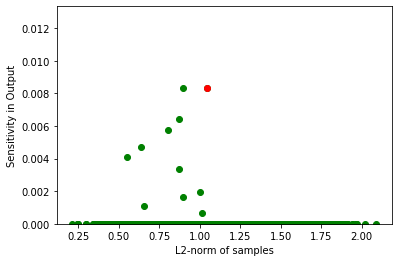

In [0]:
#Graph norm of the inputs paired with their sensitivity
axis_sens = np.hstack((train_sens, opt_sens))
axis_norm = np.hstack((train_norm, opt_norm))
 
plt.scatter(axis_norm, axis_sens, color = 'g')
plt.scatter(opt_norm, opt_sens, color = 'r')
plt.xlabel('L2-norm of samples')
plt.ylabel('Sensitivity in Output')
plt.ylim(0, axis_sens.max()+0.005)
#plt.axhline(y = thresh, color = 'black', linestyle = "--")
plt.show()

#TBC: Print the title
#Save the object as a file

### Graph 2. Sensitivity of our sample as the actual deltas deviate from the presumed one
What we want to show here is how our sample, which corresponds to a weight neuron and change delta, reacts to other levels of delta and applied to other weight neurons, either of the same layer or previous layers.

Experiments  
**Same layer**  
We take a change on just one neuron weight and retrieve a sensitive sample for that. We then test for its sensitivity if we change:  
  a. vary the magnitude of the change for the same target weight, same layer  
  b. vary the magnitude of the change but different target weight, same layer  

**Previous layer**  
  c. vary the magnitude of the change connected to the target weight, previous layer  
  d. vary the magnitude of the change not connected to the target weight, previous layer  

#### Experiment 1a
Vary the magnitude of the change for different target weights in the same layer

In [0]:
#Graph norm of the deltas paired with their sensitivity, fixed sensitive sample from our presumed delta
#What do we need from here?
#Sensitivity of our sensitive sample for different levels of delta
#Cut 1: We provide a different level of deltas manually and then test the sensitivity

shape = W['W3'].shape[0]
c1 = simulateWeightChange(0.01, shape)
Sensitivity(sensitive_sample1, W, B, c1)

array([[9.51553371e-05]])

In [0]:
opt_sens

array([[0.00833792]])

In [0]:
def varyWeightChangeExp(sens_sample, sens_change, W, B, trials, target_weight, plot_size = (8, 6)):
  """
  This function varies the magnitude of the weight change of the target weight
  for the number of trials, and then measures the sensitivity of sens_sample
  for each of those varied weight change.
  Inputs:
    sens_sample - sensitive sample
    sens_change - the weight change on which sens_sample was drawn
    W, B - trained parameters
    trials - number of trials/simulation of the weight change
    target_weight - the target neuron represented by a boolean vector
  Returns:
    A table for each of the trials and the corresponding sensitivity of sens_sample
    A graph of this table
  """
  #Percent norm and sensitivity of our sample
  percnorm_sample = np.linalg.norm(sens_change)
  opt_sens = Sensitivity(sens_sample, W, B, sens_change)

  #Step 1. We sample different levels of weight change
  table = np.empty((trials, 2))
  for i in range(trials):
    c = np.array(target_weight)*(-(i+1)*10**-1) #the percentage weight change for each of the neurons in the target layer
    #print("Change:", c)
    norm = np.linalg.norm(c)
    #print("Norm of change:", norm)

    #Step 2. For each of the change we measure our sample's sensitivity wrt it
    sens = Sensitivity(sens_sample, W, B, c)
    #print("Sensitivity of our sample:", sens)
    #print("")
    table[i, 0] = norm
    table[i, 1] = sens
  #print("Table sensitivity of our sample for diff norm change:\n", table)

  #Plot the graph
  plt.figure(figsize = plot_size)
  plt.plot(table[:, 0], table[:, 1], color = "red")
  #plt.scatter(table[:, 0], table[:, 1])
  #plt.scatter(percnorm_sample, float(opt_sens), color = "r")
  plt.ylim(0)
  plt.xlabel("Norm of percent change")
  plt.ylabel("Sensitivity of our sample")
  plt.title("The sensitivity of our sample as the actual deltas deviate from our presumed deltas")
  plt.show()
  return table

In [0]:
change_exp = dict()
change_exp['exp1'] = [1, 0, 0, 0, 0]
change_exp['exp2'] = [0, 1, 0, 0, 0]
change_exp['exp3'] = [0, 0, 1, 0, 0]
change_exp['exp4'] = [0, 0, 0, 1, 0]
change_exp['exp5'] = [0, 0, 0, 0, 1]

Target weight: [1, 0, 0, 0, 0]


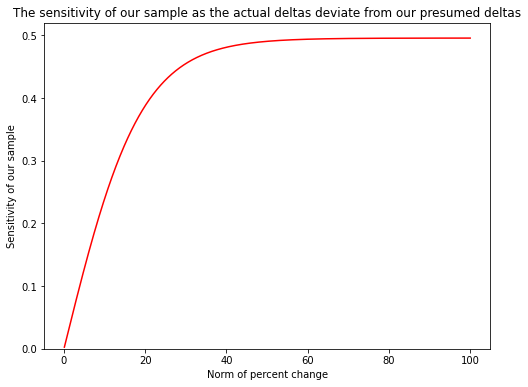

Target weight: [0, 1, 0, 0, 0]


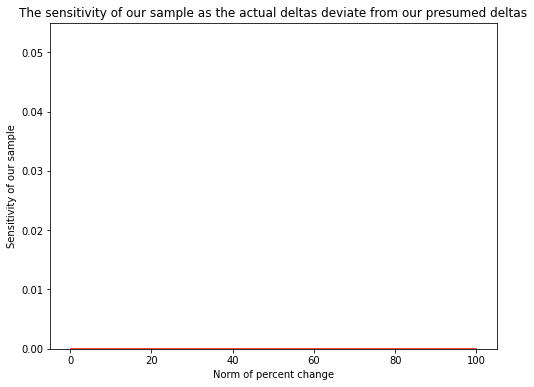

Target weight: [0, 0, 1, 0, 0]


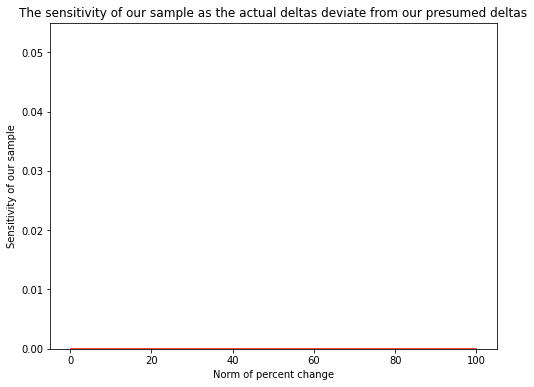

Target weight: [0, 0, 0, 1, 0]


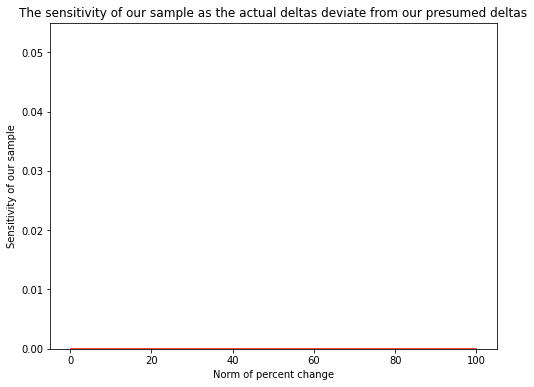

Target weight: [0, 0, 0, 0, 1]


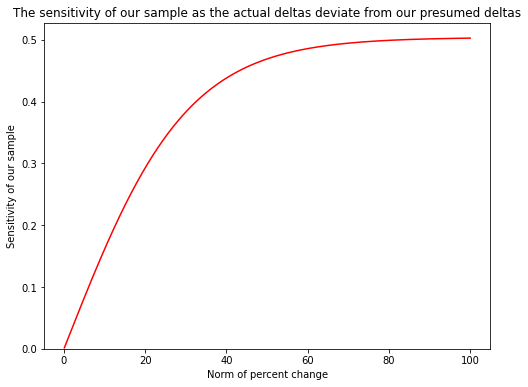

In [0]:
for i in range(5):
  print("Target weight:", change_exp['exp'+str(i+1)])
  varyWeightChangeExp(sensitive_sample1, change, W, B, 1000, change_exp['exp'+str(i+1)])

Change: [-0.  -0.  -0.  -0.  -0.1]
Norm of change: 0.1
Sensitivity of our sample: [[0.00166755]]

Change: [-0.  -0.  -0.  -0.  -0.2]
Norm of change: 0.2
Sensitivity of our sample: [[0.00333515]]

Change: [-0.  -0.  -0.  -0.  -0.3]
Norm of change: 0.30000000000000004
Sensitivity of our sample: [[0.00500277]]

Change: [-0.  -0.  -0.  -0.  -0.4]
Norm of change: 0.4
Sensitivity of our sample: [[0.00667037]]

Change: [-0.  -0.  -0.  -0.  -0.5]
Norm of change: 0.5
Sensitivity of our sample: [[0.00833792]]

Change: [-0.  -0.  -0.  -0.  -0.6]
Norm of change: 0.6000000000000001
Sensitivity of our sample: [[0.01000537]]

Change: [-0.  -0.  -0.  -0.  -0.7]
Norm of change: 0.7000000000000001
Sensitivity of our sample: [[0.0116727]]

Change: [-0.  -0.  -0.  -0.  -0.8]
Norm of change: 0.8
Sensitivity of our sample: [[0.01333986]]

Change: [-0.  -0.  -0.  -0.  -0.9]
Norm of change: 0.9
Sensitivity of our sample: [[0.01500681]]

Change: [-0. -0. -0. -0. -1.]
Norm of change: 1.0
Sensitivity of our samp

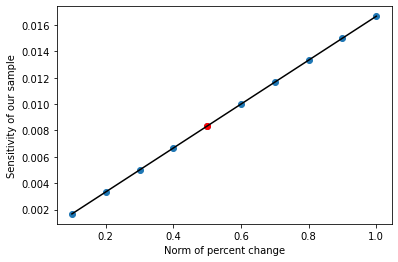

In [0]:
#Percent norm and sensitivity of our sample
percnorm_sample = np.linalg.norm(change)
#opt_sens computed above

#Step 1. We sample different levels of weight change
trials = 10
graph2a = np.empty((trials, 2))
for i in range(trials):
  c = np.array([0, 0, 0, 0, 1])*(-(i+1)*10**-1) #the percentage weight change for each of the neurons in the target layer
  print("Change:", c)
  norm = np.linalg.norm(c)
  print("Norm of change:", norm)

  #Step 2. For each of the change we measure our sample's sensitivity wrt it
  sens = Sensitivity(sensitive_sample1, W, B, c)
  print("Sensitivity of our sample:", sens)
  print("")
  graph2a[i, 0] = norm
  graph2a[i, 1] = sens
print("Table Norm of change vs sensitivity of our sample:\n", graph2a)

#Plot the graph
plt.plot(graph2a[:, 0], graph2a[:, 1], color = "black")
plt.scatter(graph2a[:, 0], graph2a[:, 1])
plt.scatter(percnorm_sample, float(opt_sens), color = "r")
plt.xlabel("Norm of percent change")
plt.ylabel("Sensitivity of our sample")
plt.show()

#### Experiment 1b
Vary the magnitude of the change of different target weights but in different layer

In [0]:
#Sens 2
#First-cut
trials = 1000
sens_inner_mat = dict() #Dictionary containing sensitivity of sample to inner weight changes
norm_inner_mat = dict() #Norm of the percent change applied in the inner weights

for i in range(5):
  sens_inner_mat['sens_' + str(i+1)] = list()
  norm_inner_mat['norm_' + str(i+1)] = list()

for i in range(trials):
  #print("\nTrial:", i+1)
  zeros = np.repeat(0, W['W2'].shape[0])
  ones = np.repeat(1, W['W2'].shape[0])
  c = np.repeat((-(i+1)*10**-1), W['W2'].shape[0])
  norm_c = np.linalg.norm(c)
  #print("Norm of c:", norm_c)
  cmat = dict()
  cmat['cmat1'] = np.array([c, zeros, zeros, zeros, zeros]).T
  cmat['cmat2'] = np.array([zeros, c, zeros, zeros, zeros]).T
  cmat['cmat3'] = np.array([zeros, zeros, c, zeros, zeros]).T
  cmat['cmat4'] = np.array([zeros, zeros, zeros, c, zeros]).T
  cmat['cmat5'] = np.array([zeros, zeros, zeros, zeros, c]).T
  #print(cmat)

  for i in range(5):
    #print("Processing target weight:", i+1)
    tweaked_inner = W.copy()
    tweaked_inner['W2'] = tweaked_inner['W2'] + np.multiply(tweaked_inner['W2'], cmat['cmat'+str(i+1)])
    #print("orig:\n", W['W2'])
    #print("tweaked:\n", tweaked_inner['W2'])
    sens_inner = np.abs(ForwardProp(sensitive_sample1, W, B)['yhat'][0] - ForwardProp(sensitive_sample1, tweaked_inner, B)['yhat'][0])[0]
    sens_inner_mat['sens_' + str(i+1)].append(sens_inner)
    norm_inner_mat['norm_' + str(i+1)].append(norm_c)
    #print("norm of change:", norm_c)
    #print("sensitivity:", sens_inner)

Sensitivity matrix: {'sens_1': [0.003216441436972417, 0.00643227161166382, 0.009647224564775236, 0.012861034627274559, 0.016073436508126704, 0.019284165381758145, 0.022492956975194156, 0.025699547654809862, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0.026155240405334013, 0

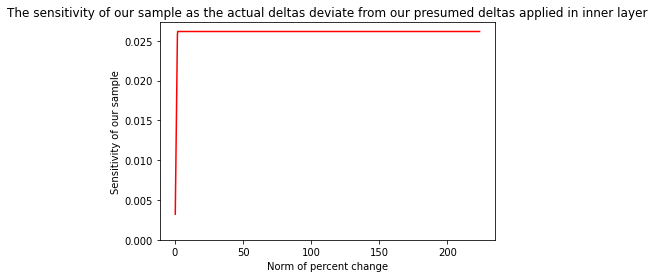

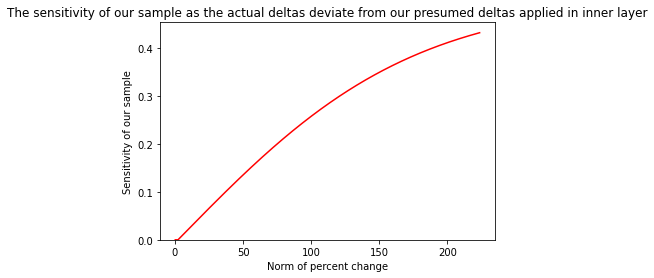

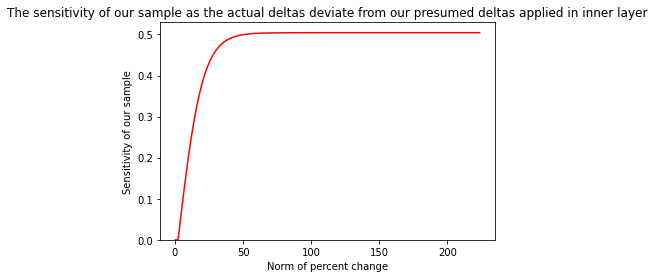

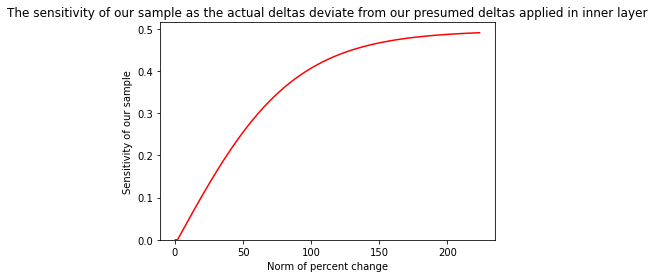

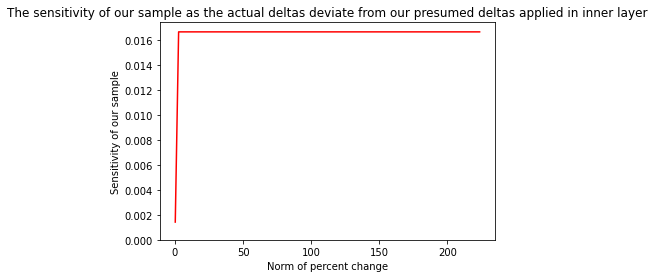

In [0]:
print("Sensitivity matrix:", sens_inner_mat)
print("Norm matrix:", norm_inner_mat)

for i in range(5):
  plt.plot(norm_inner_mat['norm_'+str(i+1)], sens_inner_mat['sens_'+str(i+1)], color = "red")
  #plt.scatter(table[:, 0], table[:, 1])
  #plt.scatter(percnorm_sample, float(opt_sens), color = "r")
  plt.ylim(0)
  plt.xlabel("Norm of percent change")
  plt.ylabel("Sensitivity of our sample")
  plt.title("The sensitivity of our sample as the actual deltas deviate from our presumed deltas applied in inner layer")
  plt.show()

### Graph 3. Runtime of retrieving sensitive samples as the number of neurons in the network grow


In [0]:
#Scalability
#Measure runtime as we grow the neurons

In [0]:
#Simulate models with different number of neurons in the network
numfeats = [5, 10, 20, 30, 40, 45, 50, 100]
nobs = 10000 #no. of observations
data = dict()
np.random.seed(1234)
# models = dict()
# for feats in numfeats:
#   print("Number of featurs per layer:", feats)
#   print("Total no. of parameters in network:", 2*feats**2 + 3*feats + 1)
#   models['model_'+str(feats)] = tf.keras.models.Sequential([tf.keras.layers.Dense(feats, input_shape = (feats, ), activation = tf.nn.relu),
#                                       tf.keras.layers.Dense(feats, activation = tf.nn.relu),
#                                       tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)])
#   models['model_'+str(feats)].compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
                
  #Generate dummy data
  #Here we simulate pixel inputs between [0, 255]
for feats in numfeats:
  data['feats_' + str(feats)] = np.random.randint(0, 255, (nobs, feats))/255 #we rescale the inputs between [0, 1]
  labels = np.random.randint(2, size=(nobs, 1))

  #Train the model, iterating on the data in batches of 32 samples
  # models['model_'+str(feats)].fit(data['feats_' + str(feats)], labels, epochs=10, batch_size=1000)
  # models['model_'+str(feats)].save("/content/gdrive/My Drive/simulated_mlp_feats" + str(feats) + ".h5")

In [0]:
data

{'feats_10': array([[0.87843137, 0.6       , 0.59607843, ..., 0.17254902, 0.9372549 ,
         0.51764706],
        [0.42352941, 0.88235294, 0.52156863, ..., 0.55294118, 0.16862745,
         0.31372549],
        [0.40784314, 0.16862745, 0.58039216, ..., 0.10980392, 0.76862745,
         0.1254902 ],
        ...,
        [0.79215686, 0.54509804, 0.82745098, ..., 0.70980392, 0.39607843,
         0.49411765],
        [0.76470588, 0.90980392, 0.76078431, ..., 0.76470588, 0.08235294,
         0.05098039],
        [0.73333333, 0.23921569, 0.36078431, ..., 0.07058824, 0.03529412,
         0.10980392]]),
 'feats_100': array([[0.43921569, 0.36078431, 0.5254902 , ..., 0.6627451 , 0.98431373,
         0.49803922],
        [0.6       , 0.28627451, 0.94117647, ..., 0.14117647, 0.34117647,
         0.72156863],
        [0.76078431, 0.14117647, 0.37647059, ..., 0.94901961, 0.80784314,
         0.81960784],
        ...,
        [0.47843137, 0.31372549, 0.40392157, ..., 0.41568627, 0.7254902 ,
         

## Alternative 2. Target value for a decision boundary and set a sensitivity threshold

In [0]:
#Set up solver here
def MLPSolverBuilder2(W, B, bandwidth, delta_range, check = False):
  """
  This function builds a solver for an MLP type of DNN. And the activation function in the hidden layers is ReLU. 
  The final neuron that is computed is the linear forward in the output layer.
  Inputs: 
    W, B - trained weight matrix and bias matrix,
    bandwidth - bandwidth of output value from the decision boundary
    delta_range - a tuple, which is the range of deltas applied in the target layer; here, the output layer

  Return: Solver for an MLP
  """
       
  #Activation fcn: ReLU in Z3
  def ReLU_z3(x):
      """
      This function defines ReLU in Z3.
      """
      return If(x<=0, 0, x)

  #Step 1: Instantiate Z3 variables as double-precision floating pt numbers
  variables = dict()

  #Linear forward variables
  for layer in range(len(W)):
      variables['z' + str(layer+1)] = list()
      for neuron in range(W['W'+str(layer+1)].shape[0]):
          variables['z' + str(layer+1)].append(Real('z' + str(layer+1) + "_" + str(neuron+1)))

  #Activation variables
  for layer in range(len(W)):
      variables['a' + str(layer)] = list()
      for neuron in range(W['W'+str(layer+1)].shape[0]):
          variables['a' + str(layer)].append(Real('a' + str(layer) + "_" + str(neuron+1)))

  #Dot product between the paramters and the z3 variables to spell out the formulas
  formulas = dict()
  for layer in range(len(W)):
      weights = np.vstack((W['W'+str(layer+1)], B['B'+str(layer+1)]))
      var = variables['a'+str(layer)].copy()
      var.append(1)
      formulas['z'+str(layer+1)] = np.dot(weights.T, var)

  #Step 2. Set up the solver
  S = Solver()

  #Linear formulas
  for layer in range(len(W)):
      for neuron in range(len(formulas['z'+str(layer+1)])):
          S.add(variables['z' + str(layer+1)][neuron] == formulas['z'+str(layer+1)][neuron])
          
  #Activation formulas
  if len(W)>1:
      for layer in range(1, len(W)):
          for neuron in range(len(variables['a'+str(layer)])):
              S.add(variables['a'+str(layer)][neuron] == ReLU_z3(variables['z'+str(layer)][neuron]))

  #Instantiate delta variables in the output layer
  deltas = list()
  for neuron in range(len(variables['a'+str(len(W)-1)])):
      deltas.append(Real('d'+str(neuron)))
  
  # print("Debug dimensions")
  # print("Length of deltas:", len(deltas))
  # print("Shape of W:", [W[k].shape for k in W.keys()])
  # print("Shape of B:", [B[k].shape for k in B.keys()])
  # print("Shape of Z:", [Z[k].shape for k in Z.keys()])
  # print("Shape of A:", [A[k].shape for k in A.keys()])

  #Additional conditions/formula(s)
  # S.add(And(variables['z'+str(len(W))][0] >= m.log((0.50-bandwidth)/(0.50+bandwidth)), variables['z'+str(len(W))][0] < 0))
  # S.add(And(variables['z'+str(len(W))][0] + np.dot(variables['a'+str(len(W)-1)], deltas) > 0,
  #         variables['z'+str(len(W))][0] + np.dot(variables['a'+str(len(W)-1)], deltas) <= m.log((0.50+bandwidth)/(0.50-bandwidth))))

  S.add(variables['z'+str(len(W))][0] <= m.log((0.50-bandwidth)/(0.50+bandwidth)))
  S.add(m.log((0.50+bandwidth)/(0.50-bandwidth)) <= variables['z'+str(len(W))][0] + np.dot(variables['a'+str(len(W)-1)], deltas))


  #Range of each delta
  dmin = delta_range[0] #min delta
  dmax = delta_range[1] #max delta
  for delta in deltas:
      S.add(And(delta>=dmin, delta<=dmax))
  S.add(np.sum(np.array(deltas)**2)!=0) #the deltas should not all be equal to zero
  
  #Check model
  runtime = CheckModel(S, check)
  if check is True:
    S
  #Store the solutions if satisfiable
  sens_sample = SensitiveSample(S, variables['a0'])
  solved_deltas = SensitiveSample(S, deltas)
  print("Solved sample:", sens_sample)
  print("Solved deltas:", solved_deltas)
  
  output = dict()
  output['model'] = S
  output['sens_sample'] = sens_sample
  output['runtime'] = runtime
  output['deltas'] = solved_deltas
  return output

In [0]:
def printOutputStats2(sens_sample, W, B, deltas):
  """
  This function prints output stats for Alternative 3.
  Inputs:
    sample - the given sample
    W - weight matrix
    deltas - the solved deltas applied to the target weights in W
  """
  tweaked_W = W.copy()
  tweaked_W['W3'] = tweaked_W['W3'] + deltas.T
  print("Sensitive sample:", sens_sample)
  print("Norm of sample:", np.linalg.norm(sens_sample))
  print("Solved deltas:", deltas)
  print("Original prediction:", ForwardProp(sens_sample, W, B)['yhat'][0][0])
  print("Tweaked prediction:", ForwardProp(sens_sample, tweaked_W, B)['yhat'][0][0])
  print("Sensitivity:", np.abs(ForwardProp(sens_sample, W, B)['yhat'] - ForwardProp(sens_sample, tweaked_W, B)['yhat'])[0][0])

In [0]:
model = tf.keras.models.load_model("/content/gdrive/My Drive/simulated_mlp_feats5.h5")
params = StoreParams(model.get_weights())
W = params['W']
B = params['B']

In [0]:
#Experiment 1
S2 = MLPSolverBuilder2(W, B, bandwidth= 0.001, delta_range = (0, 10), check = True)

sat
[d0 = 1,
 d1 = 1,
 d2 = 1,
 d3 = 1,
 d4 = 1,
 a0_1 = 86198834770133223060418056056072386940415583867800528920449909973462401375047452751827/19811348458998681566241523080082531903445683197319807181963361801090265114418956612700,
 a0_2 = 1007871313271797292651526385642900743211095205557644293843830933689588598117049504517/396226969179973631324830461601650638068913663946396143639267236021805302288379132254,
 a0_3 = 119585291984786615934655264289924134726417719036084794318048889768857314976572457623669/69339719606495385481845330780288861662059891190619325136871766303815927900466348144450,
 a0_4 = 68774127199601094209383370083051035907911235278920486697459138079397370821688476929657/13867943921299077096369066156057772332411978238123865027374353260763185580093269628890,
 a0_5 = 49025501215366886176536668194913872848337437079082523100923795794246605999781368574218/6933971960649538548184533078028886166205989119061932513687176630381592790046634814445,
 z3_1 = -439920634499042564135557156987

In [0]:
sensitive_sample2 = np.array([[86198834770133223060418056056072386940415583867800528920449909973462401375047452751827/19811348458998681566241523080082531903445683197319807181963361801090265114418956612700, 1007871313271797292651526385642900743211095205557644293843830933689588598117049504517/396226969179973631324830461601650638068913663946396143639267236021805302288379132254, 119585291984786615934655264289924134726417719036084794318048889768857314976572457623669/69339719606495385481845330780288861662059891190619325136871766303815927900466348144450, 68774127199601094209383370083051035907911235278920486697459138079397370821688476929657/13867943921299077096369066156057772332411978238123865027374353260763185580093269628890, 49025501215366886176536668194913872848337437079082523100923795794246605999781368574218/6933971960649538548184533078028886166205989119061932513687176630381592790046634814445]])
deltas = np.array([[1, 1, 1, 1, 1]])
print("sensitive sample:", sensitive_sample2)
print("deltas:", deltas)

sensitive sample: [[4.35098272 2.54367166 1.72462901 4.95921584 7.07033451]]
deltas: [[1 1 1 1 1]]


In [0]:
printOutputStats2(sensitive_sample2, W, B, deltas)

Sensitive sample: [[4.35098272 2.54367166 1.72462901 4.95921584 7.07033451]]
Norm of sample: 10.146877015071626
Solved deltas: [[1 1 1 1 1]]
Original prediction: 0.4972505237482101
Tweaked prediction: 0.501175033183932
Sensitivity: 0.003924509435721868


In [0]:
#Experiment 2
S2 = MLPSolverBuilder2(W, B, bandwidth= 0.005, delta_range = (0, 10), check = True)

sat
[d0 = 1,
 d1 = 1,
 d2 = 1,
 d3 = 1,
 d4 = 1,
 a0_1 = 22366592833376564336189681705465713571223980408647609481940521438264349617234952751827/19811348458998681566241523080082531903445683197319807181963361801090265114418956612700,
 a0_2 = 353851261512337300029408641533355043219809228824304594222717006291511205538924504517/396226969179973631324830461601650638068913663946396143639267236021805302288379132254,
 a0_3 = 23300023393207158589555142246294970903425992675063278908273774845778223667978707623669/69339719606495385481845330780288861662059891190619325136871766303815927900466348144450,
 a0_4 = 15320070181016478160912248181211513481059642756968962986287376394071680392000976929657/13867943921299077096369066156057772332411978238123865027374353260763185580093269628890,
 a0_5 = 12616799009942618241577903766741894159794786062264261479694289032034285199000118574218/6933971960649538548184533078028886166205989119061932513687176630381592790046634814445,
 z3_1 = -10299245853728822768862240268244

In [0]:
sensitive_sample2 = np.array([[22366592833376564336189681705465713571223980408647609481940521438264349617234952751827/19811348458998681566241523080082531903445683197319807181963361801090265114418956612700, 353851261512337300029408641533355043219809228824304594222717006291511205538924504517/396226969179973631324830461601650638068913663946396143639267236021805302288379132254, 23300023393207158589555142246294970903425992675063278908273774845778223667978707623669/69339719606495385481845330780288861662059891190619325136871766303815927900466348144450, 15320070181016478160912248181211513481059642756968962986287376394071680392000976929657/13867943921299077096369066156057772332411978238123865027374353260763185580093269628890, 12616799009942618241577903766741894159794786062264261479694289032034285199000118574218/6933971960649538548184533078028886166205989119061932513687176630381592790046634814445]])
deltas = np.array([[1, 1, 1, 1, 1]])
print("sensitive sample:", sensitive_sample2)
print("deltas:", deltas)

sensitive sample: [[1.12897882 0.89305193 0.33602708 1.104711   1.81956303]]
deltas: [[1 1 1 1 1]]


In [0]:
printOutputStats2(sensitive_sample2, W, B, deltas)

Sensitive sample: [[1.12897882 0.89305193 0.33602708 1.104711   1.81956303]]
Norm of sample: 2.5915719429122053
Solved deltas: [[1 1 1 1 1]]
Original prediction: 0.49497124092992273
Tweaked prediction: 0.5050614208115642
Sensitivity: 0.010090179881641514


In [0]:
#Experiment 3
S2 = MLPSolverBuilder2(W, B, bandwidth= 0.40, delta_range = (0, 10), check = True)

unsat

Computation time = 50331.43004899989ms
Model unsatisfiable
Model unsatisfiable
Solved sample: None
Solved deltas: None


## Runtime experiment

In [0]:
#Store the weights and the parameters
weights = dict()
biases = dict()
for feats in numfeats:
  params = StoreParams(models['model_'+str(feats)].get_weights())
  weights['W_'+str(feats)] = params['W']
  biases['B_'+str(feats)] = params['B']
print("Weights:", weights)
print("Biases:", biases)

Weights: {'W_5': {'W1': array([[ 0.7703323 , -0.8067729 , -0.03532959,  0.64081645,  0.7005477 ],
       [-0.01093027,  0.33719328, -0.69159704, -0.7158318 , -0.4553106 ],
       [-0.5958419 ,  0.20884591, -0.48109892,  0.24704055,  0.622141  ],
       [ 0.6359703 ,  0.46684733, -0.46495172,  0.41178158,  0.43125564],
       [-0.75547785,  0.03724517,  0.73134416, -0.34545216, -0.44479498]],
      dtype=float32), 'W2': array([[-0.2714678 , -0.72273475, -0.70515466, -0.59152657,  0.1153154 ],
       [-0.76323545, -0.14775497, -0.5385842 ,  0.08037765,  0.5311325 ],
       [-0.7341662 ,  0.08326998, -0.29556715, -0.72263074,  0.16269356],
       [-0.24535537, -0.26626685, -0.5410328 , -0.5580511 ,  0.2513275 ],
       [-0.51949084,  0.22776388,  0.05694318, -0.700433  , -0.2136744 ]],
      dtype=float32), 'W3': array([[-0.18612099],
       [ 0.6291296 ],
       [-0.14201249],
       [-0.6986526 ],
       [ 0.34453383]], dtype=float32)}, 'W_10': {'W1': array([[ 0.36210126, -0.14881432, -

In [0]:
rt_output = dict()
for feats in numfeats:
  print("Processing:", feats)
  weight = weights['W_'+str(feats)]
  bias = biases['B_'+str(feats)]
  rt_output['output_'+str(feats)] = MLPSolverBuilder2(weight, bias, bandwidth= 0.05, delta_range = (-2, 2), check = True)

Processing: 5
Debug dimensions
Length of deltas: 5
Shape of W: [(5, 5), (5, 5), (5, 1)]
Shape of B: [(5,), (5,), (1,)]
Shape of Z: [(5, 10000), (5, 10000), (1, 10000)]
Shape of A: [(5, 10000), (5, 10000), (5, 10000)]
sat
[d0 = -1,
 d1 = -1,
 d2 = -1,
 d3 = -1,
 d4 = 1,
 a0_1 = 94225060756083054895915396895715645408596387824345188149937408873398807625047452751827/19811348458998681566241523080082531903445683197319807181963361801090265114418956612700,
 a0_2 = 1180734474187617157813772341247490183836323959635906844944102779038826879367049504517/396226969179973631324830461601650638068913663946396143639267236021805302288379132254,
 a0_3 = 133067299805261291385169077099100710679643473234691898384719683375462959507822457623669/69339719606495385481845330780288861662059891190619325136871766303815927900466348144450,
 a0_4 = 79343357046010409560126112601170664473235333927083617421442029877655573946688476929657/13867943921299077096369066156057772332411978238123865027374353260763185580093269628890,


In [0]:
type(W)

dict

Show some experiments where they are satisfiable and unsatisfiable plus RT, ratio of k and m.

## Alternative 3. Transformed input

In [0]:
#Set up solver here
def MLPSolverBuilder3(W, B, sample, change_range, delta_range, target_value, check = False):
  """
  This function builds a solver for an MLP type of DNN. And the activation function in the hidden layers is ReLU. 
  The final neuron that is computed is the linear forward in the output layer.
  Inputs: 
    W, B - trained weight matrix and bias matrix,
    sample - sample input
    change_rng - range of possible values for the change applied to each input
    delta_rng - range of weight delta applied in target weight layer; here, the output layer
    target_value - the target tweaked value from the original output
    check - prints out Solver output; default is False

  Return: A dictionary containing solver output, sensitive sample, and runtime
  """

  #Step 1: Instantiate Z3 variables
  variables = dict()

  #Linear forward variables
  for layer in range(len(W)):
      variables['z' + str(layer+1)] = list()
      variables['z' + str(layer+1) + "_c"] = list()
      for neuron in range(W['W'+str(layer+1)].shape[0]):
          variables['z' + str(layer+1)].append(Real('z' + str(layer+1) + "_" + str(neuron+1)))
          variables['z' + str(layer+1) + "_c"].append(Real('z' + str(layer+1) + "_c" + str(neuron+1)))

  #Activation variables
  for layer in range(len(W)):
      variables['a' + str(layer)] = list()
      variables['a' + str(layer) + "_c"] = list()
      for neuron in range(W['W'+str(layer+1)].shape[0]):
          variables['a' + str(layer)].append(Real('a' + str(layer) + "_" + str(neuron+1)))
          variables['a' + str(layer) + "_c"].append(Real('a' + str(layer) + "_c" + str(neuron+1)))
  print(variables['a0_c'])
  #Transformed inputs and change variables for the inputs
  variables['c'] = list()
  for neuron in range(len(variables['a0'])):
    variables['c'].append(Real('c'+str(neuron+1)))
  

  #Dot product between the parameters and the z3 variables to spell out the formulas
  formulas = dict()
  for layer in range(len(W)):
      #Original
      weights = np.vstack((W['W'+str(layer+1)], B['B'+str(layer+1)]))
      var = variables['a'+str(layer)].copy()
      var.append(1)
      formulas['z'+str(layer+1)] = np.dot(weights.T, var)

      #Transformed
      var_c = variables['a'+str(layer) + "_c"].copy()
      var_c.append(1)
      formulas['z'+str(layer+1) + "_c"] = np.dot(weights.T, var_c)
  
  # for input in range(len(variables['a0_c'])):
  #   formulas['a0_c'][input] = variables['a0'][input] + variables['c'][input]
  # print(formulas['a0_c'])
  #I was born a leader after all. This time I will not leave my subjects behind!
  
  #Review from here.
  #Step 2. Set up the solver
  S = Solver()

  #Linear formulas
  for layer in range(len(W)):
      for neuron in range(len(formulas['z'+str(layer+1)])):
          #Original
          S.add(variables['z' + str(layer+1)][neuron] == formulas['z'+str(layer+1)][neuron])

          #Transformed
          S.add(variables['z' + str(layer+1) + "_c"][neuron] == formulas['z'+str(layer+1)+"_c"][neuron])
          
  #Activation formulas
  if len(W)>1:
      for layer in range(1, len(W)):
          #Original
          for neuron in range(len(variables['a'+str(layer)])):
              S.add(variables['a'+str(layer)][neuron] == ReLU_z3(variables['z'+str(layer)][neuron]))
          
          #Transformed
          for neuron in range(len(variables['a'+str(layer)])):
              S.add(variables['a'+str(layer)+"_c"][neuron] == ReLU_z3(variables['z'+str(layer)+"_c"][neuron]))


  #Instantiate delta variables in the output layer
  deltas = list()
  for neuron in range(len(A['A'+str(len(W)-1)])):
      deltas.append(Real('d'+str(neuron)))

  #Additional conditions/formula(s)
  ##Given sample input
  for input in range(len(variables['a0'])):
    S.add(variables['a0'][input] == sample[0, input]) #Here we fix the points of the sample input

  ##Transformed input
  for input in range(len(variables['a0_c'])):
    S.add(variables['a0_c'][input] == variables['a0'][input] + variables['c'][input])

  ##Range of each input change
  for change in range(len(variables['c'])):
    S.add(And(variables['c'][change] >= change_range[0], variables['c'][change] <= change_range[1]))
  S.add(np.sum(np.array(variables['c'])**2)!=0) #the change variables should not all be equal to zero

  ##We add z[3] + target value
  S.add(variables['z'+str(len(W))][0] + target_value < variables['z'+str(len(W))+"_c"][0])

  ##Range of each delta
  dmin = delta_range[0] #min delta
  dmax = delta_range[1] #max delta
  for delta in deltas:
      S.add(And(delta>=dmin, delta<=dmax))
  S.add(np.sum(np.array(deltas)**2)!=0) #the deltas should not all be equal to zero
  
  #Check model
  runtime = CheckModel(S, check)
  if check is True:
    S
  #Store the change variables if satisfiable
  change_vars = SensitiveSample(S, variables['c'])
  solved_deltas = SensitiveSample(S, deltas)
  print("Solved change variables:", change_vars)
  print("Solved weight deltas:", solved_deltas)

  output = dict()
  output['model'] = S
  output['change_vars'] = change_vars
  output['solved_deltas'] = solved_deltas
  output['runtime'] = runtime
  return output               

In [0]:
def printOutputStats3(sample, W, B, change, deltas):
  """
  This function prints output stats for Alternative 3.
  Inputs:
    sample - the given sample
    W - weight matrix
    change - the solved change variables applied to the sample
    deltas - the solved deltas applied to the target weights in W
  """
  sens_sample = sample + change
  tweaked_W = W.copy()
  tweaked_W['W3'] = tweaked_W['W3'] + deltas.T
  print("Sample:", x)
  print("Norm of sample:", np.linalg.norm(x))
  print("Solved change vars:", change)
  print("Solved deltas:", deltas)
  print("Transformed sample:", sens_sample)
  print("Norm of sens sample:", np.linalg.norm(sens_sample))
  print("Original prediction:", ForwardProp(sens_sample, W, B)['yhat'][0][0])
  print("Tweaked prediction:", ForwardProp(sens_sample, tweaked_W, B)['yhat'][0][0])
  print("Sensitivity:", np.abs(ForwardProp(sens_sample, W, B)['yhat'] - ForwardProp(sens_sample, tweaked_W, B)['yhat'])[0][0])

In [0]:
#We take a training sample
x = np.array([data['feats_5'][0]])

model = tf.keras.models.load_model("/content/gdrive/My Drive/simulated_mlp_feats5.h5")
params = StoreParams(model.get_weights())
W = params['W']
B = params['B']
print("Sample:", x, "\nModel prediction:", ForwardProp(x, W, B)['yhat'][0][0])

Sample: [[0.18431373 0.82745098 0.14901961 0.20784314 0.8       ]] 
Model prediction: 0.49960906626611296


In [0]:
#Experiment 1
exp1 = MLPSolverBuilder3(W, B, x, change_range = (-0.10, 0.10), delta_range = (-0.5, 0.5), target_value = 0.01, check = False)

[a0_c1, a0_c2, a0_c3, a0_c4, a0_c5]
sat

Computation time = 182.10486200001696ms
Solved change variables: [0, 1/16, 1/16, 3/32, 1/16]
Solved weight deltas: [0, 0, 0, 0, -1/4]


In [0]:
change = np.array([0, 1/16, 1/16, 3/32, 1/16])
deltas = np.array([[0, 0, 0, 0, -1/4]])
printOutputStats3(x, W, B, change, deltas)

Sample: [[0.18431373 0.82745098 0.14901961 0.20784314 0.8       ]]
Norm of sample: 1.1933366195595019
Solved change vars: [0.      0.0625  0.0625  0.09375 0.0625 ]
Solved deltas: [[ 0.    0.    0.    0.   -0.25]]
Transformed sample: [[0.18431373 0.88995098 0.21151961 0.30159314 0.8625    ]]
Norm of sens sample: 1.3059822019638725
Original prediction: 0.5021528402583426
Tweaked prediction: 0.4931192645488588
Sensitivity: 0.009033575709483821


In [0]:
#Experiment 2
exp2 = MLPSolverBuilder3(W, B, x, change_range = (-0.10, 0.10), delta_range = (-0.5, 0.5), target_value = 0.02, check = False)

[a0_c1, a0_c2, a0_c3, a0_c4, a0_c5]
sat

Computation time = 243.0367139999987ms
Solved change variables: [-3/32, -1/16, -819/8192, -861/16384, 6553/65536]
Solved weight deltas: [0, 0, 0, 0, -1/4]


In [0]:
change = np.array([-3/32, -1/16, -819/8192, -861/16384, 6553/65536])
deltas = np.array([[0, 0, 0, 0, -1/4]])
printOutputStats3(x, W, B, change, deltas)

Sample: [[0.18431373 0.82745098 0.14901961 0.20784314 0.8       ]]
Norm of sample: 1.1933366195595019
Solved change vars: [-0.09375    -0.0625     -0.09997559 -0.05255127  0.09999084]
Solved deltas: [[ 0.    0.    0.    0.   -0.25]]
Transformed sample: [[0.09056373 0.76495098 0.04904402 0.15529187 0.89999084]]
Norm of sens sample: 1.195765943500231
Original prediction: 0.5046091491587059
Tweaked prediction: 0.4974780511347754
Sensitivity: 0.007131098023930527


In [0]:
#Experiment 3
S3 = MLPSolverBuilder3(W, B, x, change_range = (-0.10, 0.10), delta_range = (-0.5, 0.5), target_value = 0.10, check = False)

[a0_c1, a0_c2, a0_c3, a0_c4, a0_c5]
unsat

Computation time = 179.46273800004064ms
Model unsatisfiable
Model unsatisfiable
Solved change variables: None
Solved weight deltas: None


## Graphs to show/explore
1. Sensitivity of sensitive sample compared to other possibles samples (norm).
2. For a given target layer, the sensitivity of our sample based on our presumed level of delta compared to other possible levels of delta.
3. Runtime of solving sensitive samples as we increase the number of neurons in the network: larger sample features, more nuerons in the hidden layers.
4. Sensitivity of different samples taken from different layers but all amount to the same target output value
